In [1]:
import pandas as pd
import pm4py
import numpy as np
import datetime
import re
import statistics
from math import sin, cos, sqrt, atan2, radians
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

In [2]:
#fahrt_labels="Sample Data Process Mining SWM LSA/fahrt labels.csv"
#gps_logs="Sample Data Process Mining SWM LSA/gps logs.csv"
#halte_labels="Sample Data Process Mining SWM LSA/halte labels.csv"
prozess_model="Sample Data Process Mining SWM LSA/prozess modell (linienverlauf).csv"
telegramme_logs="Sample Data Process Mining SWM LSA/telegramme logs.csv"
#trip_logs="Sample Data Process Mining SWM LSA/trip logs.csv"
#tuer_logs="Sample Data Process Mining SWM LSA/tuer logs.csv"

In [3]:
#events_gps_logs = pd.read_csv(gps_logs, sep=";", encoding='latin-1')
events_telegramme_logs = pd.read_csv(telegramme_logs, sep=";")
#events_halte_labels = pd.read_csv(halte_labels,sep=";")
#events_tuer_logs = pd.read_csv(tuer_logs,sep=";")
#events_trip_logs = pd.read_csv(trip_logs,sep=";")
events_prozess_model = pd.read_csv(prozess_model,sep=";", encoding='latin-1') #LASNR is the key   Baken 信标

### data cleaning for events_prozess_model

In [4]:
model = events_prozess_model.copy()

In [5]:
model = model.drop(columns=["REIHENFOLGE","ART","BEZEICHNUNG","TABELLENNUMMER_BAKE","FUNKKANAL","ABSTAND_HP","ABSTAND_GESAMT","ID_MP","ID_MP_KETTE","ODV_VEREINFACHT","BAKENR","SIGNAL"])
model = model.rename(columns={"BAKENTELEGRAMMNUMMER": "BTN"})
model = model[model["BTN"] != 0]#.all(axis=1)]
#model = model[model["LSANR"].notna()]
#model = model.sort_values(["LINIE", "ROUTE", "LSANR"], ascending=[True, True, True])
model["LSANR"] = model["LSANR"].astype(int)
model.reset_index(drop=True, inplace=True)
#model

In [6]:
model.insert(0, "ID", np.nan)
model["ID"] = model.apply(lambda x:'%s_%s_%s' % (x["LINIE"],x["ROUTE"],x["LSANR"]),axis=1)

In [7]:
model.insert(7, "BTN_Str", np.nan)
for n in range(len(model.index)):
    model["BTN_Str"][n] = str(model["BTN"][n]) + "_"

model["BTN_Str"] = model["BTN_Str"].apply(lambda x: x.strip())
delimiter = '_'

makeEventString = lambda x: delimiter.join(x)
makeEventString.__name__ = 'makeEventString'

numEvents = lambda x: len(x)
numEvents.__name__ = 'numEvents'


caselogs = model.pivot_table(index="ID", aggfunc={"BTN_Str": [makeEventString, numEvents]})
caselogs = caselogs.reset_index()
caselogs.columns = ["ID", "BTN_sequence", "Anzahl_der_Telegramme"]

model = pd.merge(model, caselogs, on="ID")

model = model.drop(columns=["BTN_Str"])

#model

D:\Anaconda3_\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3_\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [8]:
model

,ID,LINIE,ROUTE,LSANR,BTN,LAT_SOLL,LON_SOLL,BTN_sequence,Anzahl_der_Telegramme
0,43_1_15,43,1,15,605,"48,127603","11,603204",605__612__614_,3
1,43_1_15,43,1,15,612,"48,126223","11,600759",605__612__614_,3
2,43_1_15,43,1,15,614,"48,125416","11,599497",605__612__614_,3
3,43_1_132,43,1,132,5316,"48,125401","11,599483",5316__5317__5318_,3
4,43_1_132,43,1,132,5317,"48,124923","11,598784",5316__5317__5318_,3
...,...,...,...,...,...,...,...,...,...
13050,154_24_612,154,24,612,24486,"48,161","11,56192",24485__24486_,2
13051,154_904_67,154,904,67,2688,"48,150233","11,575986",2688__2689__2690__2691_,4
13052,154_904_67,154,904,67,2689,"48,149675","11,578012",2688__2689__2690__2691_,4
13053,154_904_67,154,904,67,2690,"48,149109","11,580144",2688__2689__2690__2691_,4


In [9]:
model.to_csv (r'edited_model.csv', index = False, header=True)

### data cleaning for event _telegramme_logs

In [10]:
events = events_telegramme_logs.copy()

In [11]:
events = events.drop_duplicates()
#drop rows with different fahrt_linie and Linie or fahrt_route and Route
events = events.drop(events[(events["fahrt_linie"]!=events["Linie"])|(events["fahrt_route"]!=events["Route"])].index)

#events['Zeitpunkt'] = pd.to_datetime(events['Zeitpunkt'])
#events['fahrt_start'] = pd.to_datetime(events['fahrt_start'])
#events['relativetime(s)'] = (events['Zeitpunkt'] - events['fahrt_start']).dt.total_seconds().astype(int)

#"fahrt_linie","fahrt_route","fahrzeug_nummer"
events = events.drop(columns=["fahrt_start","fahrt_ende","fahrzeug_adresse"])
events["fahrt_betriebstag"] =events.apply(lambda x:'%s%s%s' % (x["fahrt_betriebstag"][2:4],x["fahrt_betriebstag"][5:7],x["fahrt_betriebstag"][8:10]),axis=1)
events.reset_index(drop=True, inplace=True)
#events

In [16]:
events

,fahrt_linie,fahrt_route,fahrt_INIT_TRIP_ID,fahrt_betriebstag,fahrzeug_nummer,Funkadresse,Zeitpunkt,Odometer,Linie,Route,BTN,LAT,LON
0,54,17,40879020,200317,9165,833,2020-03-17 08:53:48.000,45677,54,17,5840,"48,10984167","11,58868167"
1,54,17,40879020,200317,9165,833,2020-03-17 08:53:58.000,45767,54,17,5841,"48,11000333","11,587605"
2,54,17,40879020,200317,9165,833,2020-03-17 08:54:15.000,45910,54,17,5842,"48,11053167","11,58568667"
3,54,17,40879020,200317,9165,833,2020-03-17 08:54:27.000,46014,54,17,45680,"48,11089167","11,58437667"
4,54,17,40879020,200317,9165,833,2020-03-17 08:54:41.000,46151,54,17,45681,"48,11135","11,58279167"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72960,54,1,40788477,200317,5785,805,2020-03-17 18:46:05.000,65294,54,1,6382,"48,11222833","11,50231333"
72961,54,1,40788477,200317,5785,805,2020-03-17 18:46:11.000,65326,54,1,16681,"48,11223167","11,50177833"
72962,54,1,40788477,200317,5785,805,2020-03-17 18:46:33.000,65356,54,1,16682,"48,11222167","11,50138"
72963,54,1,40788477,200317,5785,805,2020-03-17 18:46:58.000,65624,54,1,16689,"48,11224","11,49778667"


### merge to one data log

In [12]:
#some events from log "events" may have wrong linie and route
merged_log = pd.merge(left=events, right=model, how='left', left_on=['Linie','Route','BTN'], right_on=['LINIE','ROUTE','BTN'])
merged_log.reset_index(drop=True, inplace=True)

merged_log["caseID"] = merged_log.apply(lambda x:'%s_%s_%s' % (x["ID"],x["fahrt_betriebstag"],x["fahrt_INIT_TRIP_ID"]),axis=1)
merged_log = merged_log.drop(columns=["fahrt_INIT_TRIP_ID","ID","LINIE","ROUTE","fahrt_betriebstag"])
#"LSANR","Linie","Route"
merged_log = merged_log[["caseID","BTN","fahrzeug_nummer","Funkadresse","Odometer","Zeitpunkt","BTN_sequence","Anzahl_der_Telegramme","LAT","LON","LAT_SOLL","LON_SOLL", "Linie", "Route", "LSANR"]]
merged_log

,caseID,BTN,fahrzeug_nummer,Funkadresse,Odometer,Zeitpunkt,BTN_sequence,Anzahl_der_Telegramme,LAT,LON,LAT_SOLL,LON_SOLL,Linie,Route,LSANR
0,54_17_146_200317_40879020,5840,9165,833,45677,2020-03-17 08:53:48.000,5840__5841__5842_,3,"48,10984167","11,58868167","48,109819","11,588789",54,17,146
1,54_17_146_200317_40879020,5841,9165,833,45767,2020-03-17 08:53:58.000,5840__5841__5842_,3,"48,11000333","11,587605","48,109972","11,587744",54,17,146
2,54_17_146_200317_40879020,5842,9165,833,45910,2020-03-17 08:54:15.000,5840__5841__5842_,3,"48,11053167","11,58568667","48,110481","11,58587",54,17,146
3,54_17_1142_200317_40879020,45680,9165,833,46014,2020-03-17 08:54:27.000,45680__45681__45682_,3,"48,11089167","11,58437667","48,110845","11,58455",54,17,1142
4,54_17_1142_200317_40879020,45681,9165,833,46151,2020-03-17 08:54:41.000,45680__45681__45682_,3,"48,11135","11,58279167","48,111312","11,582909",54,17,1142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72960,54_1_159_200317_40788477,6382,5785,805,65294,2020-03-17 18:46:05.000,6377__6378__6381__6382_,4,"48,11222833","11,50231333","48,11221","11,50248",54,1,159
72961,54_1_417_200317_40788477,16681,5785,805,65326,2020-03-17 18:46:11.000,16681__16682__16689__16690_,4,"48,11223167","11,50177833","48,112196","11,501868",54,1,417
72962,54_1_417_200317_40788477,16682,5785,805,65356,2020-03-17 18:46:33.000,16681__16682__16689__16690_,4,"48,11222167","11,50138","48,112194","11,501531",54,1,417
72963,54_1_417_200317_40788477,16689,5785,805,65624,2020-03-17 18:46:58.000,16681__16682__16689__16690_,4,"48,11224","11,49778667","48,112234","11,498008",54,1,417


In [11]:
#merged_log

In [19]:
caseID_list = merged_log["caseID"].tolist()
caseID_list = list(dict.fromkeys(caseID_list))
number_cases = len(caseID_list)
number_cases

20721

### detect numerical and sequential anomalies

In [13]:
def check_numerical_anomalies(eventlog):
    caseID_list = eventlog["caseID"].tolist()
    caseID_list = list(dict.fromkeys(caseID_list))
    
    numerical_anomalies = pd.DataFrame()
    
    number_numerical_anomalies = 0
    
    for caseID in caseID_list:
        sublist = eventlog.loc[eventlog["caseID"]==caseID]
        #sublist.reset_index(drop=True, inplace=True)
        
        number_soll = sublist["Anzahl_der_Telegramme"].iloc[0]
        number_real = len(sublist)
        if number_soll != number_real:
            #print("{} {}".format("Anomalie mit Anzahl bei case: ", sublist["caseID"][0], "LSANR:", sublist["LSANR"]))
            numerical_anomalies = numerical_anomalies.append(sublist)
            number_numerical_anomalies += 1
            eventlog = eventlog.drop(eventlog[eventlog["caseID"]==caseID].index)
    
    #print("{}{}".format("number of numerical anomalies is ", number_numerical_anomalies))
    return eventlog, numerical_anomalies, number_numerical_anomalies


In [14]:
def check_sequential_anomalies(eventlog):
    caseID_list = eventlog["caseID"].tolist()
    caseID_list = list(dict.fromkeys(caseID_list))
    
    sequential_anomalies = pd.DataFrame()
    
    number_sequential_anomalies = 0
    
    for caseID in caseID_list:
        sublist = eventlog.loc[eventlog["caseID"]==caseID]
        #sublist.reset_index(drop=True, inplace=True)
        
        sequence = re.findall(r'\d+', sublist["BTN_sequence"].iloc[0])
        for n in range(len(sequence)):
            if sublist["BTN"].iloc[n] != int(sequence[n]):
                #print("{} {}".format("Anomalie mit Reihefolge bei case: ", sublist["caseID"][0]))
                number_sequential_anomalies += 1
                sequential_anomalies = sequential_anomalies.append(sublist)
                eventlog = eventlog.drop(eventlog[eventlog["caseID"]==caseID].index)
                break
            
    #print("{}{}".format("number of sequential anomalies is ", number_sequential_anomalies))
    return eventlog, sequential_anomalies, number_sequential_anomalies

In [15]:
merged_log, numerical_anomalies, number_numerical_anomalies = check_numerical_anomalies(merged_log)
merged_log, sequential_anomalies, number_sequential_anomalies = check_sequential_anomalies(merged_log)
merged_log = merged_log.reset_index(drop=True)

In [21]:
merged_log

,caseID,BTN,fahrzeug_nummer,Funkadresse,Odometer,Zeitpunkt,BTN_sequence,Anzahl_der_Telegramme,LAT,LON,LAT_SOLL,LON_SOLL,Linie,Route,LSANR
0,54_17_146_200317_40879020,5840,9165,833,45677,2020-03-17 08:53:48.000,5840__5841__5842_,3,"48,10984167","11,58868167","48,109819","11,588789",54,17,146
1,54_17_146_200317_40879020,5841,9165,833,45767,2020-03-17 08:53:58.000,5840__5841__5842_,3,"48,11000333","11,587605","48,109972","11,587744",54,17,146
2,54_17_146_200317_40879020,5842,9165,833,45910,2020-03-17 08:54:15.000,5840__5841__5842_,3,"48,11053167","11,58568667","48,110481","11,58587",54,17,146
3,54_17_1142_200317_40879020,45680,9165,833,46014,2020-03-17 08:54:27.000,45680__45681__45682_,3,"48,11089167","11,58437667","48,110845","11,58455",54,17,1142
4,54_17_1142_200317_40879020,45681,9165,833,46151,2020-03-17 08:54:41.000,45680__45681__45682_,3,"48,11135","11,58279167","48,111312","11,582909",54,17,1142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70306,54_1_159_200317_40788477,6382,5785,805,65294,2020-03-17 18:46:05.000,6377__6378__6381__6382_,4,"48,11222833","11,50231333","48,11221","11,50248",54,1,159
70307,54_1_417_200317_40788477,16681,5785,805,65326,2020-03-17 18:46:11.000,16681__16682__16689__16690_,4,"48,11223167","11,50177833","48,112196","11,501868",54,1,417
70308,54_1_417_200317_40788477,16682,5785,805,65356,2020-03-17 18:46:33.000,16681__16682__16689__16690_,4,"48,11222167","11,50138","48,112194","11,501531",54,1,417
70309,54_1_417_200317_40788477,16689,5785,805,65624,2020-03-17 18:46:58.000,16681__16682__16689__16690_,4,"48,11224","11,49778667","48,112234","11,498008",54,1,417


In [22]:
merged_log.to_csv (r'merged_log.csv', index = False, header=True)

In [17]:
numerical_anomalies

In [17]:
sequential_anomalies[:30]

,caseID,BTN,fahrzeug_nummer,Funkadresse,Odometer,Zeitpunkt,BTN_sequence,Anzahl_der_Telegramme,LAT,LON,LAT_SOLL,LON_SOLL,Linie,Route,LSANR
785,154_1_771_200317_40732726,30842,5281,59,118381,2020-03-17 20:03:33.000,30842__30841__30840_,3,"48,15667833","11,6418","48,156697","11,641701",154,1,771
786,154_1_771_200317_40732726,30841,5281,59,118447,2020-03-17 20:03:53.000,30842__30841__30840_,3,"48,15721","11,64195","48,157252","11,641954",154,1,771
787,154_1_771_200317_40732726,30841,5281,59,118558,2020-03-17 20:04:31.000,30842__30841__30840_,3,"48,15817667","11,64204333","48,157252","11,641954",154,1,771
15203,154_1_771_200317_40954712,30842,9237,798,23566,2020-03-17 07:43:29.000,30842__30841__30840_,3,"48,15670333","11,64171833","48,156697","11,641701",154,1,771
15204,154_1_771_200317_40954712,30841,9237,798,23631,2020-03-17 07:43:51.000,30842__30841__30840_,3,"48,15719","11,64197667","48,157252","11,641954",154,1,771
15205,154_1_771_200317_40954712,30841,9237,798,23737,2020-03-17 07:44:30.000,30842__30841__30840_,3,"48,15817833","11,64204667","48,157252","11,641954",154,1,771
15314,154_1_771_200317_40954720,30842,9237,798,121171,2020-03-17 15:03:40.000,30842__30841__30840_,3,"48,15667333","11,64169667","48,156697","11,641701",154,1,771
15315,154_1_771_200317_40954720,30841,9237,798,121242,2020-03-17 15:03:57.000,30842__30841__30840_,3,"48,15723333","11,64197","48,157252","11,641954",154,1,771
15316,154_1_771_200317_40954720,30841,9237,798,121344,2020-03-17 15:04:28.000,30842__30841__30840_,3,"48,15814167","11,64203","48,157252","11,641954",154,1,771
15425,154_1_771_200317_40954724,30842,9237,798,169938,2020-03-17 18:44:13.000,30842__30841__30840_,3,"48,15665167","11,64172","48,156697","11,641701",154,1,771


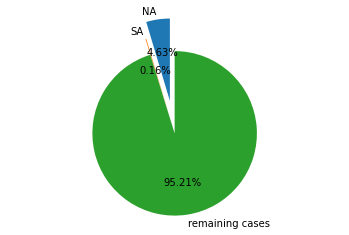

In [33]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'NA', 'SA', 'remaining cases'
sizes = [number_numerical_anomalies, number_sequential_anomalies, number_cases - number_numerical_anomalies - number_sequential_anomalies]
explode = (0.4, 0.2, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [20]:
perc1 = "{0:.2%}".format(number_numerical_anomalies/number_cases)
perc2 = "{0:.2%}".format(number_sequential_anomalies/number_cases)
print("{}{},{}{}".format(number_numerical_anomalies," numerical anomalies",perc1," percentage of all cases"))
print("{}{},{}{}".format(number_sequential_anomalies," sequential anomalies",perc2," percentage of all cases"))

960 numerical anomalies,4.63% percentage of all cases
33 sequential anomalies,0.16% percentage of all cases
